In [9]:
"""
Simulation of selfish mining 
Analyze and simulate relative pool revenue (Rpool) with confidence intervals

David Starobinski
April 17, 2023
"""



# import required packages - 
# do not add other packages

import math
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt



'''
Define simulation Global Parameters
'''
def determineBlock():
  coin_toss = np.random.uniform(0,1)
  if coin_toss < 0.5:
      coin_toss = 0 # Pool finds a block
  else:
      coin_toss = 1 # Others find a block
  return coin_toss

ALPHA = [0.1, 0.2, 0.25, 0.3,0.33333, 0.4, 0.45, 0.475] # Selfish Mining Power (Pool Size)
NUMALPHA = len(ALPHA)
GAMMA = 1.0 # Change this parameter as needed
ITERATIONS = 30 # number of independent simulations
CONF_LEVEL = 0.05 # confidence interval is 100*(1-CONF_LEVEL) percent
STEPS = 10**4 #Number of steps in each iteration

# Average relative pool revenue in each iteration
Rpool = np.zeros((ITERATIONS,NUMALPHA)) 

'''
Main Simulator Loop
'''
for a in range(NUMALPHA):
    for itr in range(ITERATIONS):
        curr_state = 0  # initialize DTMC state
        r_pool = 0      # initialize running sum of mining pool revenue
        r_other = 0     # initialize running sum of honest nodes revenue
        flag = False    # initialize flag variable (True only if in state 0')
        for s in range(STEPS): # At each step, update state and collected revenue, as appropriate
            
            p0 = (ALPHA[a] - 2*(ALPHA[a])**2) / (ALPHA[a]*(2*(ALPHA[a])**3-4*(ALPHA[a])**2+1)) #probability for state 0
            p0prime = ((1-ALPHA[a])*(ALPHA[a]-2*(ALPHA[a]**2)))/(1-4*(ALPHA[a]**2)+2*(ALPHA[a]**3)) #probability for state 0'
            p1 = (ALPHA[a] - 2*(ALPHA[a]**2)) / (2*(ALPHA[a]**3)-4*(ALPHA[a]**2)+1) #probability for state p1
            p2 = ((ALPHA[a]/(1-ALPHA[a]))**(2-1))*((ALPHA[a]-2*(ALPHA[a]**2))/(2*(ALPHA[a]**3)-4*(ALPHA[a]**2)+1)) #probability for state p2
            
            blockFound = determineBlock()
            if curr_state == 0 and flag == False: # state 0
              if blockFound == 1: # others found a block
                curr_state = 0
                flag = False
                r_other =r_other + (p0 * (1 - ALPHA[a])) * 1  #case e-others get revenue for 1 block
              elif blockFound == 0: # pool found a block
                curr_state = 1

            elif curr_state == 1: #state 1
              if blockFound == 1: #others found a block
                curr_state = 0
                flag = True # to make state 0'
              elif blockFound == 0: #pool found a block
                curr_state = 2 

            elif curr_state == 0 and flag == True:
              if blockFound == 1:
                randomToss = determineBlock()
                if randomToss == 1: #case c-1 block revenue for both selfish and honest miners
                  r_other = r_other + (p0prime * GAMMA * (1 - ALPHA[a])) * 1
                  r_pool = r_pool + (p0prime * GAMMA * (1 - ALPHA[a]))* 1
                else: #case d-2 blocks revenue for honest miners
                  r_other = r_other + ((p0prime * (1 - GAMMA) * (1 - ALPHA[a])) * 2)*2
              elif blockFound == 0: #case b-2 blocks revenue for selfish miners
                r_pool = r_pool + ((p0prime * ALPHA[a]) * 2)*2
              curr_state = 0
              flag = False

            elif curr_state == 2: #state 2
              if blockFound == 1: #others found a block
                r_pool = r_pool + ((p2 * (1 - ALPHA[a])) * 2)*2 #case g-pool gets revenue for 2 blocks
                curr_state = 0
                flag = False
              elif blockFound == 0: #pool found a block
                curr_state = 3

            elif curr_state >= 3: #state >= 3
              if blockFound == 1: 
                k = curr_state
                pk = (((ALPHA[a])/(1-ALPHA[a]))**(k-1))*((ALPHA[a]-2*(ALPHA[a]**2))/(2*(ALPHA[a]**3)-4*(ALPHA[a]**2)+1))
                r_pool = r_pool + pk * (1 - ALPHA[a]) * 1 #case h
                curr_state -= 1
              elif blockFound == 0: 
                curr_state += 1
                
        Rpool[itr,a]=r_pool/(r_pool + r_other)
            


In [13]:
'''
Compute Statistics     
'''
SampleM_Rpool = np.mean(Rpool, axis = 0) # Fill code - Sample Mean of Rpool averaged over all iterations

stderr = stats.sem(Rpool, axis=0)
tval = stats.t.ppf(1-CONF_LEVEL/2, df=ITERATIONS-1)
Error = tval * stderr
'''
Print simulation results against analytical results
'''
print('Statistical results for Gamma = %.3f' %GAMMA)
Analytical_Rpool = np.zeros(NUMALPHA) # Analytical values
for a in range(NUMALPHA):
    Analytical_Rpool[a] = ((ALPHA[a]*(1 - ALPHA[a])**2)* (4*ALPHA[a] + GAMMA*(1 - 2*ALPHA[a])) -ALPHA[a]**3)/ (1 - ALPHA[a]*(1 + (2 - ALPHA[a])*ALPHA[a]))
    print('Alpha = %.5f' %ALPHA[a])
    print('Analytical Relative Pool revenue is %.5f' %Analytical_Rpool[a])
    print('Sample Mean Relative Pool revenue is %.5f with error %.5f' %((SampleM_Rpool[a]+CONF_LEVEL+Error[a]), Error[a]))
    

Statistical results for Gamma = 1.000
Alpha = 0.10000
Analytical Relative Pool revenue is 0.10919
Sample Mean Relative Pool revenue is 0.09359 with error 0.00191
Alpha = 0.20000
Analytical Relative Pool revenue is 0.23516
Sample Mean Relative Pool revenue is 0.20120 with error 0.01096
Alpha = 0.25000
Analytical Relative Pool revenue is 0.30488
Sample Mean Relative Pool revenue is 0.29477 with error 0.02827
Alpha = 0.30000
Analytical Relative Pool revenue is 0.38062
Sample Mean Relative Pool revenue is 0.35766 with error 0.02096
Alpha = 0.33333
Analytical Relative Pool revenue is 0.43589
Sample Mean Relative Pool revenue is 0.41138 with error 0.00966
Alpha = 0.40000
Analytical Relative Pool revenue is 0.56744
Sample Mean Relative Pool revenue is 0.55368 with error 0.01646
Alpha = 0.45000
Analytical Relative Pool revenue is 0.70942
Sample Mean Relative Pool revenue is 0.70915 with error 0.02007
Alpha = 0.47500
Analytical Relative Pool revenue is 0.81873
Sample Mean Relative Pool revenue 

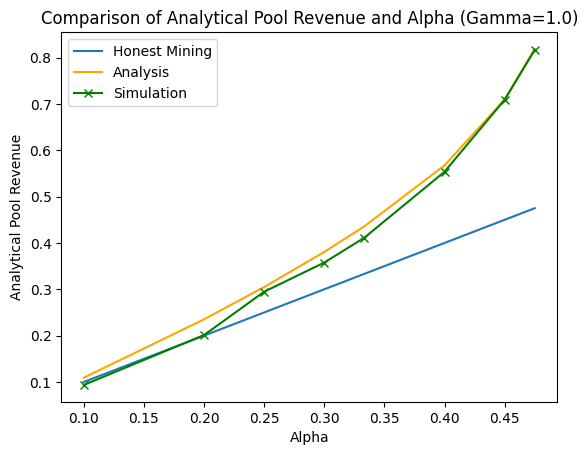

In [12]:
'''
Plot simulation results against analytical results
'''
# Plot of Honest mining
plt.plot(ALPHA, ALPHA, label='Honest Mining') # Honest Mining
# Plot of Analytical Rpool    
plt.plot(ALPHA, Analytical_Rpool, color='orange', label='Analysis') #Analytical Revenue of Pool
#Plot of Simulated Rpool with confidence intervals
plt.plot(ALPHA, SampleM_Rpool+CONF_LEVEL+Error, marker = 'x',color = 'green', label = 'Simulation')
#Add title, label, legend, and display
plt.title(f'Comparison of Analytical Pool Revenue and Alpha (Gamma={GAMMA})')
plt.xlabel('Alpha')
plt.ylabel('Analytical Pool Revenue')
plt.legend()
plt.show()
